In [108]:
import pandas as pd 
import numpy as np 
from pandas import datetime 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt 
import seaborn as sns 

from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

# Train 

In [3]:
train = pd.read_csv('train.csv',
                    parse_dates = True,
                    index_col = 'Date')

store = pd.read_csv('store.csv')

test = pd.read_csv('test.csv', parse_dates = True)

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [4]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [42]:
# Closed stores with 0 sales
x = train[(train.Open == 0) & (train.Sales == 0)] 
print('Number of closed stores with no sales: ', x.shape)

# Opened stores with 0 sales 
y = train[(train.Open == 1) & (train.Sales == 0)]
print('Number of open stores with no sales: ', y.shape)

# Closed stores  
z = train[(train.Open != 0) & (train.Sales != 0)]
print('Opened Stores with sales: ', z.shape)

# Stores opened on Sundays
train[(train.Open == 1) & (train.DayOfWeek == 7)]['Store'].unique()

Number of closed stores with no sales:  (172817, 13)
Number of open stores with no sales:  (54, 13)
Opened Stores with sales:  (844338, 13)


array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877],
      dtype=int64)

# Stores & Model data

In [49]:
df = pd.read_csv('model_data.csv', parse_dates = True, 
                index_col = 'Date')
# store = pd.read_csv('store.csv')
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
dtype: int64

In [11]:
df.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


In [12]:
df.groupby('StateHoliday')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StateHoliday,,,,,,,,
0,986159.0,5947.483893,3767.890619,0.0,3967.0,5849.0,7936.0,41551.0
a,20260.0,290.735686,1870.281698,0.0,0.0,0.0,0.0,38484.0
b,6690.0,214.311510,1816.918138,0.0,0.0,0.0,0.0,38722.0
c,4100.0,168.733171,1492.274865,0.0,0.0,0.0,0.0,32169.0


In [28]:
df.groupby('StoreType')['Sales', 'Customers'].sum()

,Sales,Customers
StoreType,,
a,3165334859,363541434
b,159231395,31465621
c,783221426,92129705
d,1765392943,156904995


### Type B has lower counts of observations 
### Type A has higher counts of customers 

In [50]:
df['Sale/Customer'] = df['Sales'] / df['Customers']
df['Sale/Customer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: Sale/Customer, dtype: float64

In [43]:
df.dtypes

Date                          object
Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance            int64
CompetitionOpenSinceMonth      int64
CompetitionOpenSinceYear       int64
Promo2                         int64
Promo2SinceWeek               object
Promo2SinceYear               object
PromoInterval                 object
quarter                        int64
weekday                        int64
year                           int64
month                          int64
day                            int64
week_of_year                   int64
day_of_year                    int64
day_of_week                    int64
IsStateHoliday                 int64
D

In [44]:
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,weekday,year,month,day,week_of_year,day_of_year,day_of_week,IsStateHoliday,Day,Sale/Customer
0,2015-07-31,1,5,5263,555,1,1,0,1,c,...,1,2015,7,31,31,212,4,0,Weekday,9.482883
1,2015-07-30,1,4,5020,546,1,1,0,1,c,...,1,2015,7,30,31,211,3,0,Weekday,9.194139
2,2015-07-29,1,3,4782,523,1,1,0,1,c,...,1,2015,7,29,31,210,2,0,Weekday,9.143403
3,2015-07-28,1,2,5011,560,1,1,0,1,c,...,1,2015,7,28,31,209,1,0,Weekday,8.948214
4,2015-07-27,1,1,6102,612,1,1,0,1,c,...,1,2015,7,27,31,208,0,0,Weekday,9.970588


# Seasonality

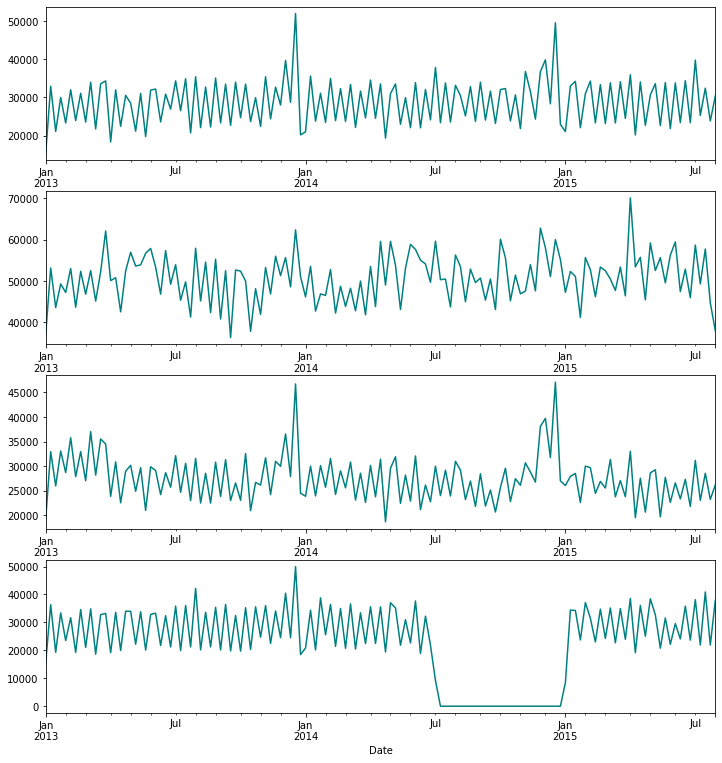

In [46]:
k = 'teal'

train['Sales'] = train['Sales'] * 1.0

sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

sales_a.resample('W').sum().plot(color = k, ax = ax1)
sales_b.resample('W').sum().plot(color = k, ax = ax2)
sales_c.resample('W').sum().plot(color = k, ax = ax3)
sales_d.resample('W').sum().plot(color = k, ax = ax4)

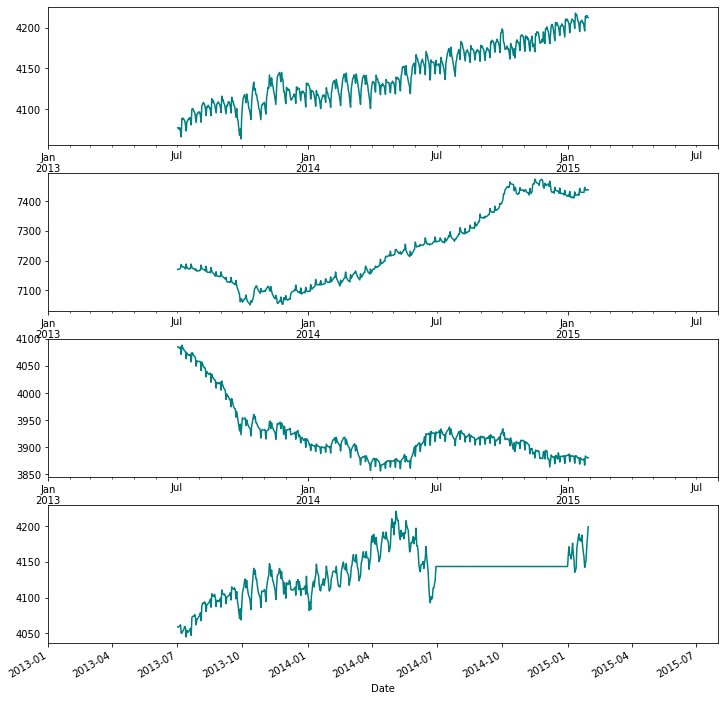

In [47]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = k, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = k, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = k, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = k, ax = ax4)

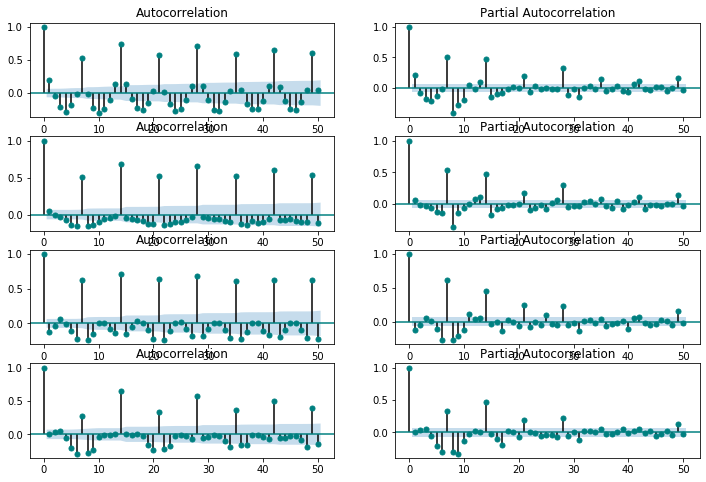

In [49]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = k)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = k)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = k)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = k)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = k)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = k)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = k)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = k)

plt.show()

# Prophet

- store 1, type C (not opened on Sundays)
- store 85, type B (opened on Sundays)

In [117]:
# Holidays df
df = pd.read_csv('train.csv', parse_dates = True)

st_holidays = df[(df.StateHoliday == 'a') | 
                 (df.StateHoliday == 'b') & 
                 (df.StateHoliday == 'c')].loc[:, 'Date'].values
                                            
sch_holidays = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

sth = pd.DataFrame({'ds': pd.to_datetime(st_holidays),
                    'holiday': 'state_holiday'
                    })

sch = pd.DataFrame({'ds': pd.to_datetime(sch_holidays),
                    'holiday': 'school_holiday'
                    })

hols = pd.concat((sth, sch))
hols.head()

,ds,holiday
0,2015-06-04,state_holiday
1,2015-06-04,state_holiday
2,2015-06-04,state_holiday
3,2015-06-04,state_holiday
4,2015-06-04,state_holiday


In [134]:
# drop closed stores & 0 sales 
df = df[(df['Open'] != 0) & (df['Sales'] != 0)]

sales_1 = df[df.Store == 1].loc[:, ['Date', 'Sales']]
sales_85 = df[df.Store == 85].loc[:, ['Date', 'Sales']]

sales_1.sort_index(ascending = False, inplace = True)
sales_1['Date'] = pd.DatetimeIndex(sales_1['Date'])

sales_85.sort_index(ascending = False, inplace = True)
sales_85['Date'] = pd.DatetimeIndex(sales_85['Date'])

sales_1 = sales_1.rename(columns = {'Date': 'ds',
                          'Sales': 'y'})

sales_85 = sales_85.rename(columns = {'Date': 'ds',
                          'Sales': 'y'})

# sales_1.head()
sales_85.tail()

,ds,y
4544,2015-07-27,7788
3429,2015-07-28,7533
2314,2015-07-29,7719
1199,2015-07-30,7187
84,2015-07-31,7791


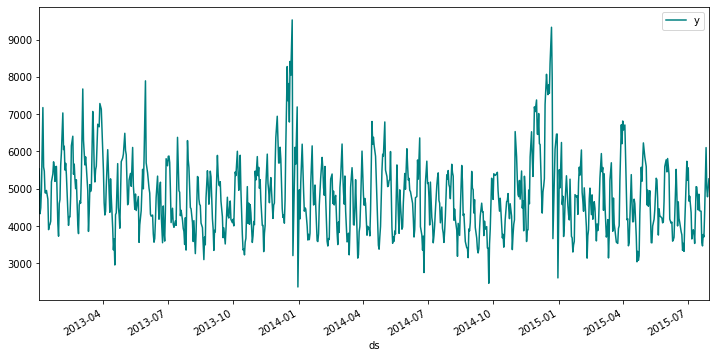

In [130]:
ax = sales_1.set_index('ds').plot(figsize = (12, 6),
                            color = 'teal')
plt.show()

In [135]:
model = Prophet(interval_width = .95,
               holidays = hols)

model.fit(sales_1)

model2 = Prophet(interval_width = .95,
               holidays = hols)

model2.fit(sales_85)


future_dates = model.make_future_dataframe(periods = 6*7) # 6 weeks

future_dates.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-07


In [139]:
forecasts = model.predict(future_dates)

forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

forecasts2 = model2.predict(future_dates)

forecasts2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-02,5976.097169,3398.705295,8607.534967
1,2013-01-03,5919.597846,3302.300762,8539.565236
2,2013-01-04,6222.656682,3559.093997,8715.916629
3,2013-01-05,5065.347529,2430.302706,7711.150347
4,2013-01-07,7015.858072,4583.839218,9744.000212


In [140]:
forecasts2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,5244.330963,2576.312950,7862.663524
817,2015-09-06,11006.920193,8256.140119,13618.707291
818,2015-09-07,7177.607859,4385.376349,9843.276536
819,2015-09-08,6100.271344,3448.151353,8565.922384
820,2015-09-09,5979.500761,3426.166847,8849.346998
821,2015-09-10,5954.732344,3373.930107,8709.216589
822,2015-09-11,6291.265589,3622.891748,8811.216071


In [141]:
fcs = forecasts2[['ds', 'yhat']].rename(columns = {'Date': 'ds', 
                                                  'Forecast': 'yhat'})     
fcs.head()

,ds,yhat
0,2013-01-02,5976.097169
1,2013-01-03,5919.597846
2,2013-01-04,6222.656682
3,2013-01-05,5065.347529
4,2013-01-07,7015.858072


Store 1 RMSE: 833.6548135402328
Store 85 RMSE: 2086.6041037506557
Store 1 RMSPE: 0.13549252682965585
Store 85 RMSPE: 0.12567833965138708


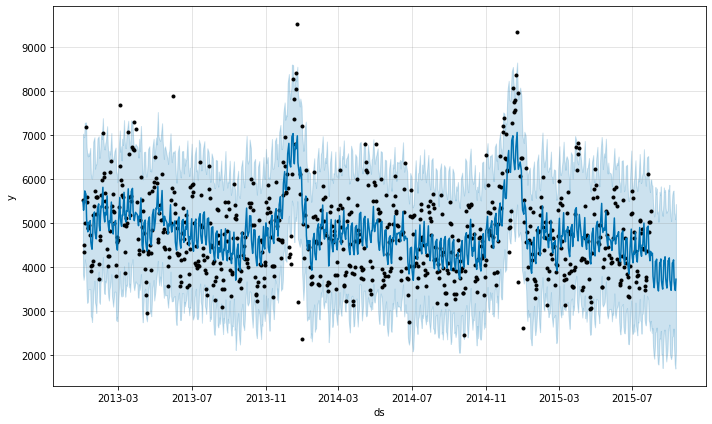

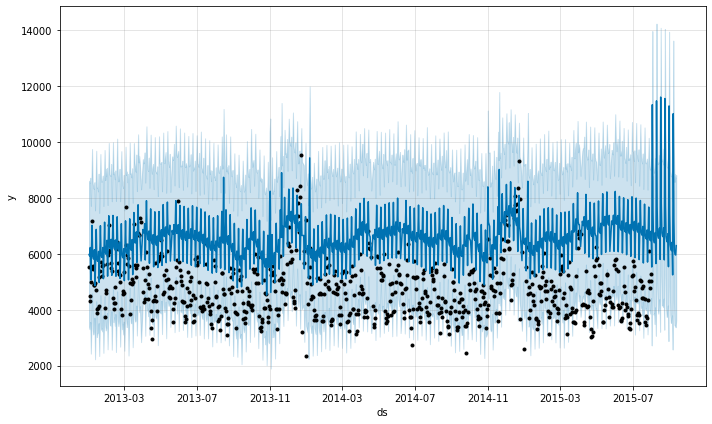

In [143]:
model.plot(forecasts);
model.plot(forecasts2);

from sklearn.metrics import mean_squared_error
from math import sqrt

metric_df = forecasts.set_index('ds')[['yhat']].join(sales_1.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

metric_df2 = forecasts.set_index('ds')[['yhat']].join(sales_85.set_index('ds').y).reset_index()
metric_df2.dropna(inplace=True)

error = mean_squared_error(metric_df.y, metric_df.yhat)
error2 = mean_squared_error(metric_df2.y, metric_df2.yhat)

print('Store 1 RMSE: {}'. format(sqrt(error)))

print('Store 85 RMSE: {}'. format(sqrt(error2)))

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

error = rmspe(sales_1['y'], fcs['yhat'])
error2 = rmspe(sales_85['y'], fcs['yhat'])

print('Store 1 RMSPE:', error)
print('Store 85 RMSPE:', error2)

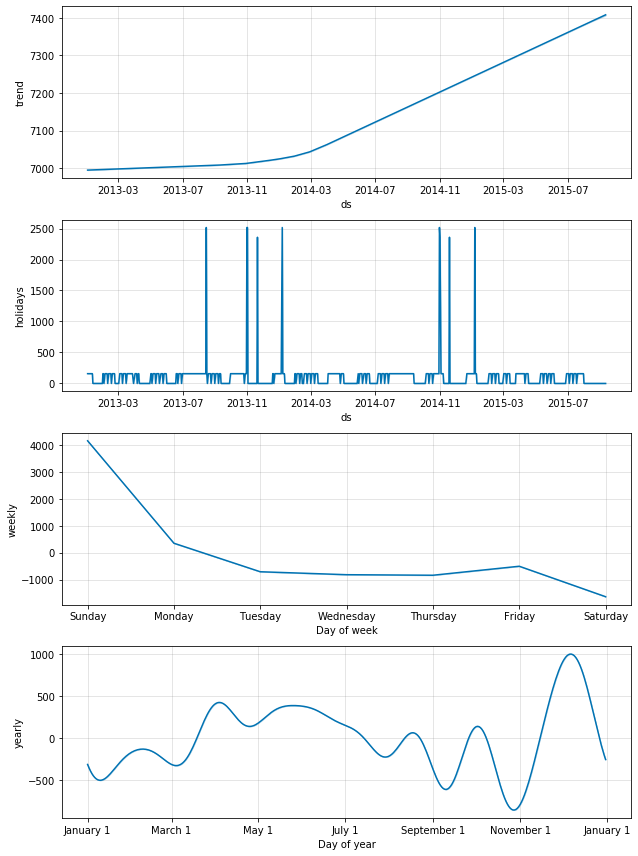

In [144]:
model2.plot_components(forecasts2);

# XGB 

- All stores
- removing opened days with no sales 

In [31]:
test = pd.read_csv('test.csv', parse_dates = True, index_col = 'Date')
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [32]:
store = pd.read_csv('store.csv')
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [33]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(),
                                    inplace = True)

store.fillna(0, inplace = True)

In [34]:
train = pd.read_csv('train.csv', parse_dates = True, index_col = 'Date')
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['Sale/Customer'] = train['Sales']/train['Customers']
train['Sale/Customer'].describe()

df = pd.merge(train, store, 
              how = 'inner',
              on = 'Store')

df.shape

(844338, 22)

In [35]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


In [36]:
# Should be open (Non-holidays)
test.fillna(1, inplace = True)

In [37]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

df.Assortment.replace(mappings, inplace = True)
df.StoreType.replace(mappings, inplace = True)
df.StateHoliday.replace(mappings, inplace = True)
df.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

test_store = pd.merge(test, store, 
                      how = 'inner', on = 'Store')

In [38]:
test_store['CompetitionOpen'] = 12*(test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)

test_store['PromoOpen'] = 12*(test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

In [41]:
df['StateHoliday'] = df['StateHoliday'].apply(lambda x: float(x))
df['Assortment'] = df['Assortment'].apply(lambda x: float(x))

test_store['StateHoliday'] = test_store['StateHoliday'].apply(lambda x: float(x))
test_store['Assortment'] = test_store['Assortment'].apply(lambda x: float(x))

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

independents = [x for x in df.columns if x not in ['Customers', 
                                                            'Sales', 
                                                            'Sale/Customer']]
y = np.log(df.Sales) # log transformation of Sales
X = df

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [70]:
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Sale/Customer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear'],
      dtype='object')

In [21]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [13]:
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [15]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train[independents], y_train)
dtest = xgb.DMatrix(X_test[independents], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

# xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      #early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

In [83]:
import scipy.stats as st
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

[00:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=300, n_jobs=0, num_parallel_tree=1,
       objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, subsample=0.8, tree_method=None,
       validate_parameters=False, verbosity=None)

In [22]:
params_new = {
    'base_score':.5,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': .85,
    'gamma': 0, 
    'gpu_id': -1,
    'importance_type': 'gain',
    'learning_rate': .1,
    'max_delta_step': 0,
    'max_depth': 10,
    'min_child_weight': 1,
    'monotone_consraints': None,
    'n_estimators': 300,
    'n_jobs': 0,
    'num_parallel_tree': 1,
    'objecive': 'reg:linear',
    'random_state': 42,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'seed': 42,
    'subsample': .8,
    'tree_method': None,
    'validate_parameters': False,
    'verbosity': None} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.44339	test-rmse:7.44309	train-rmspe:0.99953	test-rmspe:0.99953
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.70077	test-rmse:6.70048	train-rmspe:0.99882	test-rmspe:0.99882
[2]	train-rmse:6.03254	test-rmse:6.03223	train-rmspe:0.99755	test-rmspe:0.99755
[3]	train-rmse:5.43133	test-rmse:5.43100	train-rmspe:0.99541	test-rmspe:0.99541
[4]	train-rmse:4.89021	test-rmse:4.88984	train-rmspe:0.99203	test-rmspe:0.99203
[5]	train-rmse:4.40344	test-rmse:4.40310	train-rmspe:0.98695	test-rmspe:0.98696
[6]	train-rmse:3.96558	test-rmse:3.96523	train-rmspe:0.97974	test-rmspe:0.97975
[7]	train-rmse:3.57177	test-rmse:3.57138	train-rmspe:0.96994	test-rmspe:0.96995
[8]	train-rmse:3.21740	test-rmse:3.21704	train-rmspe:0.95717	test-rmspe:0.95717
[9]	train-rmse:2.89869	test-rmse:2.89835	train-rmspe:0.94115	test-rmspe:0.94114
[10]	train-rmse:2.61202	test-rmse:2.61165	train-rmspe:0

[100]	train-rmse:0.14638	test-rmse:0.14895	train-rmspe:0.18244	test-rmspe:0.16287
[101]	train-rmse:0.14488	test-rmse:0.14751	train-rmspe:0.18101	test-rmspe:0.16132
[102]	train-rmse:0.14361	test-rmse:0.14625	train-rmspe:0.17988	test-rmspe:0.15999
[103]	train-rmse:0.14314	test-rmse:0.14585	train-rmspe:0.17907	test-rmspe:0.15953
[104]	train-rmse:0.14226	test-rmse:0.14499	train-rmspe:0.17822	test-rmspe:0.15861
[105]	train-rmse:0.14186	test-rmse:0.14461	train-rmspe:0.17763	test-rmspe:0.15824
[106]	train-rmse:0.14093	test-rmse:0.14372	train-rmspe:0.17647	test-rmspe:0.15731
[107]	train-rmse:0.13989	test-rmse:0.14269	train-rmspe:0.17553	test-rmspe:0.15623
[108]	train-rmse:0.13921	test-rmse:0.14206	train-rmspe:0.17476	test-rmspe:0.15557
[109]	train-rmse:0.13786	test-rmse:0.14072	train-rmspe:0.17356	test-rmspe:0.15417
[110]	train-rmse:0.13662	test-rmse:0.13952	train-rmspe:0.17234	test-rmspe:0.15289
[111]	train-rmse:0.13578	test-rmse:0.13872	train-rmspe:0.17189	test-rmspe:0.15200
[112]	train-rmse

[200]	train-rmse:0.10439	test-rmse:0.11041	train-rmspe:0.13268	test-rmspe:0.12188
[201]	train-rmse:0.10414	test-rmse:0.11017	train-rmspe:0.13250	test-rmspe:0.12165
[202]	train-rmse:0.10394	test-rmse:0.11001	train-rmspe:0.13232	test-rmspe:0.12148
[203]	train-rmse:0.10381	test-rmse:0.10990	train-rmspe:0.13221	test-rmspe:0.12137
[204]	train-rmse:0.10358	test-rmse:0.10969	train-rmspe:0.13197	test-rmspe:0.12113
[205]	train-rmse:0.10330	test-rmse:0.10944	train-rmspe:0.13170	test-rmspe:0.12086
[206]	train-rmse:0.10300	test-rmse:0.10919	train-rmspe:0.13144	test-rmspe:0.12061
[207]	train-rmse:0.10285	test-rmse:0.10908	train-rmspe:0.13131	test-rmspe:0.12051
[208]	train-rmse:0.10267	test-rmse:0.10893	train-rmspe:0.13114	test-rmspe:0.12033
[209]	train-rmse:0.10250	test-rmse:0.10879	train-rmspe:0.13098	test-rmspe:0.12019
[210]	train-rmse:0.10219	test-rmse:0.10852	train-rmspe:0.13063	test-rmspe:0.11985
[211]	train-rmse:0.10214	test-rmse:0.10848	train-rmspe:0.13059	test-rmspe:0.11981
[212]	train-rmse

First validation yelds RMSPE: 0.110709


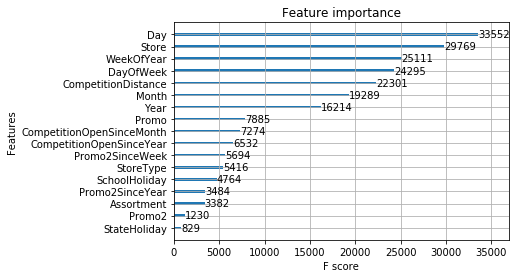

In [23]:
yhat = model_final.predict(xgb.DMatrix(X_test[independents]))
error = rmspe(X_test.Sales.values, np.exp(yhat))

print('First validation yelds RMSPE: {:.6f}'.format(error))

xgb.plot_importance(model_final)

In [42]:
unseen = xgb.DMatrix(test_store[independents])
test_p = model_final.predict(unseen)

forecasts = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_p)})
# forecasts
forecasts.head()

,Id,Sales
Date,,
2015-09-17,1,4235.434082
2015-09-17,2,4387.080566
2015-09-17,3,4942.727051
2015-09-17,4,5196.984375
2015-09-17,5,5427.250000
